# RPC Anomaly Detection Project - Data Analyst Interview Case

## Objective:
### Identify anomalies in Revenue Per Click (RPC) for Oct 25, based on historical performance from Oct 17–24.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load historical and current day data
historical_df = pd.read_csv("5_2_17_oct_2024-24_oct_2024.csv")
oct25_df = pd.read_csv("5_1_25_oct_2024.csv")

In [3]:
historical_df.head()

,day,offer_id,reward_id,app_id,country_code,default_reward_initiations,default_reward_completions,revenue_amount_in_usd
0,10/21/2024,86159,167356,offerwall_320,IN,0,0,0.0
1,10/24/2024,260317,523448,offerwall_616,IN,2,0,0.0
2,10/22/2024,161390,298765,offerwall_165,IN,0,0,0.0
3,10/18/2024,239457,453505,offerwall_431,BR,2,0,0.0
4,10/22/2024,127554,228455,offerwall_286,IN,0,0,0.0


In [4]:
oct25_df.head()

,day,offer_id,reward_id,app_id,country_code,default_reward_initiations,default_reward_completions,revenue_amount_in_usd
0,10/25/2024,239456,453498,in_cash,ET,0,0,0.0
1,10/25/2024,85709,166860,chillar,KH,0,0,0.0
2,10/25/2024,161441,298842,offerwall_327,IN,0,0,0.0
3,10/25/2024,127554,228451,offerwall_431,ZA,1,0,0.0
4,10/25/2024,259828,521370,offerwall_325,IN,0,0,0.0


In [5]:
# Compute RPC
for df in [historical_df, oct25_df]:
    df['RPC'] = df['revenue_amount_in_usd'] / df['default_reward_initiations']

In [6]:
# Filter out noisy data (low RPC and low revenue)
# historical_df = historical_df[(historical_df['RPC'] > 1) & (historical_df['revenue_amount_in_usd'] > 10)]
# oct25_df = oct25_df[(oct25_df['RPC'] > 1) & (oct25_df['revenue_amount_in_usd'] > 10)]

print("Historical rows:", len(historical_df))
print("Oct 25 rows:", len(oct25_df))

Historical rows: 659794
Oct 25 rows: 79248


In [7]:
# Calculate historical average RPC (loose match: offer_id + country_code)
avg_rpc = (
    historical_df.groupby(['offer_id', 'country_code'])
    .agg(avg_rpc=('RPC', 'mean'))
    .reset_index()
)

In [8]:
# Adjust multiplier for testing (Adding Threshold)
avg_rpc['threshold'] = avg_rpc['avg_rpc'] * 3  # Adjusted from 5 to 3 to catch more anomalie

In [9]:
# Merge threshold into Oct 25 data (loose join)
oct25_merged = oct25_df.merge(avg_rpc, on=['offer_id', 'country_code'], how='left')

print("Merged rows:", len(oct25_merged))
print("Missing threshold values:", oct25_merged['threshold'].isna().sum())

Merged rows: 79248
Missing threshold values: 6846


In [10]:
# Identify anomalies
anomalies = oct25_merged[oct25_merged['RPC'] > oct25_merged['threshold']]
print("Anomalies found:", len(anomalies))

Anomalies found: 1421


In [11]:
# Export anomalies
anomalies.to_csv("rpc_anomalies_oct25.csv", index=False)

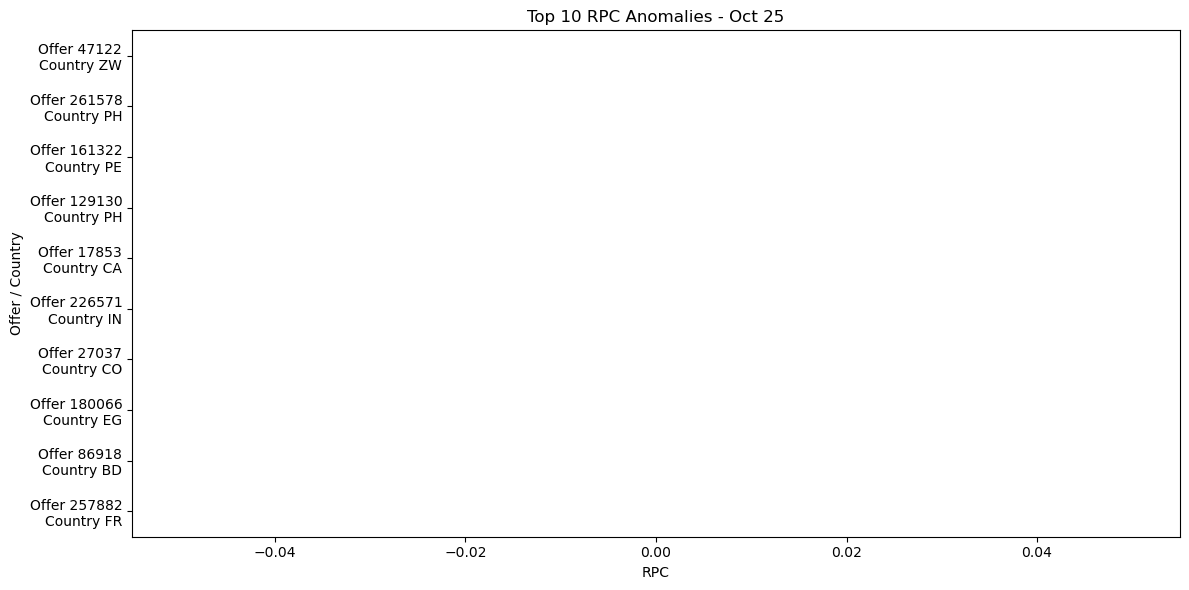

In [12]:
if not anomalies.empty:
    plt.figure(figsize=(12,6))
    top_anomalies = anomalies.sort_values(by='RPC', ascending=False).head(10)
    sns.barplot(
        x='RPC',
        y=top_anomalies.apply(lambda row: f"Offer {row.offer_id}\nCountry {row.country_code}", axis=1),
        data=top_anomalies,
        palette='Reds_r'
    )
    plt.title('Top 10 RPC Anomalies - Oct 25')
    plt.xlabel('RPC')
    plt.ylabel('Offer / Country')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No anomalies exceeded threshold.")

## Summary:
### * We built a simple anomaly detection system using historical averages (RPC = revenue/initiations)
### * Thresholds are defined as 3× the historical RPC (can be tuned).
### * Uses minimal assumptions and can be adapted for real-time pipelines.
### * Looser matching used (offer + country)
### * Output anomalies shown and saved
### * Logs help debug when no anomalies are found